<a href="https://colab.research.google.com/github/renmiamu/NUS_AI4fin/blob/main/ai4fi_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import yfinance as yf

tickers = ['AAPL', 'MSFT', 'GOOG']
data = yf.download(tickers, start="2018-01-01", end="2024-01-01")
close = data['Close']
close = close.dropna()
close.tail()


/tmp/ipython-input-14-2030560908.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,GOOG,MSFT
Date,,,
2023-12-22,192.192551,141.876663,370.375732
2023-12-26,191.646561,141.976074,370.454895
2023-12-27,191.745819,140.604233,369.871490
2023-12-28,192.172714,140.445175,371.067902
2023-12-29,191.130325,140.097229,371.819366


/tmp/ipython-input-15-2146013401.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Signal'][50:] = np.where(df['MA20'][50:] > df['MA50'][50:], 1, 0)
/tmp/ipython-input-15-2146013401.py:14: SettingWithCopyWarning: 
A value is trying to

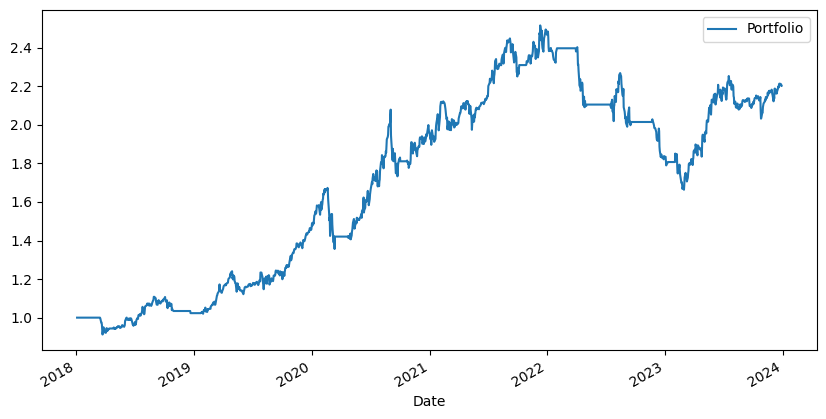

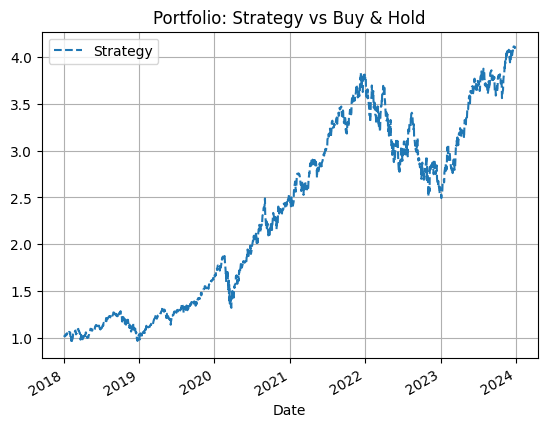

In [15]:
import pandas as pd
import numpy as np

# 存储每只股票的策略结果
strategy_results = {}

# 遍历每只股票
for ticker in tickers:
    df = pd.DataFrame(close[ticker])
    df.columns = ['Price']
    df['MA20'] = df['Price'].rolling(20).mean()
    df['MA50'] = df['Price'].rolling(50).mean()
    df['Signal'] = 0
    df['Signal'][50:] = np.where(df['MA20'][50:] > df['MA50'][50:], 1, 0)
    df['Position'] = df['Signal'].diff()
    df['Returns'] = df['Price'].pct_change()
    df['Strategy'] = df['Returns'] * df['Signal'].shift(1)
    strategy_results[ticker] = df

# 汇总策略收益
strategy_df = pd.DataFrame({
    ticker: strategy_results[ticker]['Strategy'] for ticker in tickers
})

# 删除空值行并计算组合策略收益
strategy_df.dropna(inplace=True)
strategy_df['Portfolio'] = strategy_df.mean(axis=1)

# 同样汇总 Buy & Hold 收益
bh_df = pd.DataFrame({
    ticker: strategy_results[ticker]['Returns'] for ticker in tickers
})
bh_df.dropna(inplace=True)
bh_df['Portfolio'] = bh_df.mean(axis=1)

# 绘制累计收益图
(1 + strategy_df[['Portfolio']]).cumprod().plot(label='Strategy', figsize=(10,5))
(1 + bh_df[['Portfolio']]).cumprod().plot(label='Buy & Hold', linestyle='--')
plt.title('Portfolio: Strategy vs Buy & Hold')
plt.grid(True)
plt.legend(['Strategy', 'Buy & Hold'])
plt.show()


In [16]:
import matplotlib.pyplot as plt

# 计算组合 Sharpe Ratio
strategy_ret = strategy_df['Portfolio']
sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252)
print(f"Strategy Sharpe Ratio: {sharpe:.2f}")

# 计算最大回撤
cum_ret = (1 + strategy_ret).cumprod()
rolling_max = cum_ret.cummax()
drawdown = cum_ret / rolling_max - 1
max_dd = drawdown.min()
print(f"Max Drawdown: {max_dd:.2%}")



Strategy Sharpe Ratio: 0.83
Max Drawdown: -33.88%
